# EX 01: Logistic Regression

by Christoph Rindchen, Johannes Maul and Lukas Klinger

Imports:

In [11]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

## 1.0 Loading Data:

In [12]:
digits = load_digits()
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

Reduce data:

In [13]:
mask = np.logical_or(target == 3, target == 8)
targets_reduced = target[mask]
data_reduced = data[mask]

In [15]:
data_x = np.hstack((data_reduced, np.ones((357, 1))))

data_y = np.ones_like(targets_reduced)
data_y[targets_reduced == 8] = -1

## 1.1 Classification with sklearn

In [16]:
lambdas = [0.01, 0.1, 1, 10, 100]
scores = list()

for lambda_i in lambdas:
    log_reg_model = LogisticRegression(C=lambda_i, solver="liblinear")
    score = cross_val_score(log_reg_model, data_x, data_y)

    scores.append(np.mean(score))

    print(f"[lambda {lambda_i}]: {scores[-1]}")

print(f"\nThe best lambda was {lambdas[np.argmax(scores)]}")

[lambda 0.01]: 0.9580203442879499
[lambda 0.1]: 0.9636541471048513
[lambda 1]: 0.966431924882629
[lambda 10]: 0.9636150234741784
[lambda 100]: 0.9608372456964005

The best lambda was 1


## 1.2 Optimization Methods

Helper Methods:

In [17]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [18]:
def gradient(beta, X, y, lambda_=1):
    # see lecture from the 03.05.22 under Log. Reg. obj. with regularization

    N = X.shape[0]

    if len(X.shape) > 1:
        return beta.T + lambda_ / N * (sigmoid(-y * (X @ beta)) @ (-np.stack([y] * X.shape[1]).T * X))
    else:
        return beta.T + lambda_ / N * (sigmoid(-y * (X @ beta)) * (-y * X))

<div style="color: green; font-weight: bold">Comment</div>

The gradient function is almost the same. The only diference is the placement of lambda parameter. Beta should be divided by lambda. In this case since best lambda is 1 it doesn't make any difference but if we change lambda to different value then the results of this gradnient function and the one presented in example solution are different. Because the beta shape is (65,) and not (65, 1) they needed to take under consideration two cases (if else). Using beta with shape (65, 1) is more elegant because we dont need if condition then.

In [19]:
def predict(beta, X, th=0):
    y = beta @ X.T
    y[y < th] = -1
    y[y >= th] = 1

    return y

In [20]:
def zero_one_loss(y_prediction, y_truth):
    return np.mean(y_prediction != y_truth)

<div style="color: green; font-weight: bold">Comment</div>

Other help methods are the same

Optimization Methods:

In [21]:
def gradient_descent(X, y, learning_rate, beta_0, num_of_iterations=10, **kwargs):
    beta = beta_0

    for i in range(num_of_iterations):
        grad = gradient(beta, X, y)

        beta = beta - learning_rate * grad

    return beta

<div style="color: green; font-weight: bold">Comment</div>

Gradnient descent is the same

In [22]:
def stochastic_gradient_descent(X, y, learning_rate, beta_0, num_of_iterations=150, gamma=0, **kwargs):
    beta = beta_0

    for i in range(num_of_iterations):
        rand_idx = np.random.randint(0, X.shape[0])
        
        grad = gradient(beta, X[rand_idx], y[rand_idx])

        learning_rate = learning_rate / (1 + gamma * i)
        beta = beta - learning_rate * grad

    return beta

<div style="color: green; font-weight: bold">Comment</div>

Stochastic gradient is the same 

In [23]:
def minibatch_gradient_descent(X, y, learning_rate, beta_0, num_of_iterations=150, batch_size=10, gamma=0, **kwargs):
    beta = beta_0

    for i in range(num_of_iterations):
        shuffled_idxs = np.random.permutation(range(X.shape[0]))[:batch_size]

        grad = gradient(beta, X[shuffled_idxs, :], y[shuffled_idxs])

        learning_rate = learning_rate / (1 + gamma * i)
        beta = beta - learning_rate * grad

    return beta

<div style="color: green; font-weight: bold">Comment</div>

Mini batch is the same. Different random function was used but it does the same job. They also choose instances without replacement. 

In [24]:
def momentum_stochastic_gradient_descent(X, y, learning_rate, beta_0, mu=0.99, num_of_iterations=150, g_0=0, gamma=0, **kwargs):
    g = g_0
    beta = beta_0

    for i in range(num_of_iterations):
        rand_idx = np.random.randint(0, X.shape[0])
        grad = gradient(beta, X[rand_idx], y[rand_idx])

        g = mu * g + (1 - mu) * grad

        learning_rate = learning_rate / (1 + gamma * i)
        beta = beta - learning_rate * g

    return beta

<div style="color: green; font-weight: bold">Comment</div>

Momentum is the same.

In [25]:
def adam(X, y, learning_rate, beta_0, mu_1=0.9, mu_2=0.999, num_of_iterations=150, g_0=0, q_0 = 0, eps=10**(-8), **kwargs):
    g = g_0
    q = q_0
    beta = beta_0

    for i in range(num_of_iterations):
        rand_idx = np.random.randint(0, X.shape[0])
        grad = gradient(beta, X[rand_idx], y[rand_idx])

        g = mu_1 * g + (1 - mu_1) * grad
        q = mu_2 * q + (1 - mu_2) * grad**2
        g_tilde = g / (1 - mu_1**(i + 1))
        q_tilde = q / (1 - mu_2**(i + 1))

        beta = beta - learning_rate * g_tilde / (np.sqrt(q_tilde) + eps)

    return beta

<div style="color: green; font-weight: bold">Comment</div>

Adam is the same.

In [26]:
def stochastic_average_gradient(X, y, learning_rate, beta_0, num_of_iterations=150, lambda_=1, **kwargs):
    beta = beta_0.reshape((X.shape[1], 1))
    gamma = 0.1
    tau = 0.1

    g_i_stored = (-np.stack([y] * X.shape[1]).T * X) * sigmoid(-np.stack([y] * X.shape[1]).T * (X @ beta))
    g = np.mean(g_i_stored, axis=0, keepdims=True)

    for i in range(num_of_iterations):
        learning_rate = learning_rate / (1 + gamma * i)

        rand_idx = np.random.randint(0, X.shape[0])

        g_i = -y[rand_idx] * X[rand_idx] * sigmoid(-y[rand_idx] * np.dot(X[rand_idx], beta))
        g += (g_i - g_i_stored[rand_idx,:]) / y.shape[0]

        beta = beta * (1 - tau / lambda_) - tau * g.T

        g_i_stored[rand_idx, :] = g_i

    return np.squeeze(beta)

<div style="color: green; font-weight: bold">Comment</div>

Stochastic average gradient works the same. The differece is with calculating g_i_stored. Because y has different shape than y in example solution they had to do some "tricks" using np.stack function. The g_i_stored is the same in both cases but the code in example solution is cleaner. Apart from that the code is essentialy the same. Also they use np.squeeze to change beta shape to (65, )

In [27]:
def dual_coordinate_ascent(X, y, learning_rate, beta_0, num_of_iterations=150, lambda_=1, eps=10**(-5), **kwargs):
    alpha = np.random.uniform(0, 1, y.shape)
    beta = lambda_ / y.shape[0] * (X.T @ (y * alpha))  # ignore given beta_0

    for i in range(num_of_iterations):
        rand_idx = np.random.randint(0, X.shape[0])

        f_1 = y[rand_idx] * (X[rand_idx] @ beta) + np.log(alpha[rand_idx] / (1 - alpha[rand_idx]))
        f_2 = lambda_ / y.shape[0] * (X[rand_idx] @ X[rand_idx].T) + 1 / ((alpha[rand_idx]) * (1 - alpha[rand_idx]))

        alpha_t = alpha[rand_idx]
        alpha[rand_idx] = np.clip(alpha[rand_idx] - f_1 / f_2, eps, 1-eps)
        beta += (alpha[rand_idx] - alpha_t) * y[rand_idx] * X[rand_idx].T * lambda_ / y.shape[0]

    return beta

<div style="color: green; font-weight: bold">Comment</div>

Dual coordinate ascent is the same 

In [28]:
def newton_raphson(X, y, learning_rate, beta_0, num_of_iterations=10, lambda_=1, **kwargs):
    beta = beta_0

    for i in range(num_of_iterations):
        z = X @ beta
        y_tilde = y / sigmoid(y * z)
        W = np.diag((lambda_ / X.shape[0] * (sigmoid(z) * sigmoid(-z))).reshape(-1,))
        beta = (np.linalg.inv(np.eye(X.shape[1]) + (X.T @ W).dot(X))).dot(X.T).dot(W).dot(z + y_tilde)

    return beta

<div style="color: green; font-weight: bold">Comment</div>

Newton is the same 

In [29]:
IMPLEMENTED_OPTIMIZERS = [gradient_descent, stochastic_gradient_descent, minibatch_gradient_descent, momentum_stochastic_gradient_descent, adam, stochastic_average_gradient, dual_coordinate_ascent, newton_raphson]

## 1.3 Comparison

In [30]:
X, X_test , y, y_test = model_selection.train_test_split(data_x, data_y, test_size=0.3, random_state=0)

In [31]:
infos = dict()

for method in IMPLEMENTED_OPTIMIZERS:
    kf = model_selection.KFold(n_splits=10)

    infos[method.__name__] = list()

    print(method.__name__)

    for tau in [0.001, 0.01, 0.1]:
        if method == adam:
            tau = 10**(-4)

        for mu in [0.1, 0.2, 0.5]:
            for gamma in [0.0001, 0.001, 0.01]:

                cross_val_loss = list()

                for train_index, validation_index in kf.split(X):
                    X_train , X_validation = X[train_index], X[validation_index]
                    y_train , y_validation = y[train_index], y[validation_index]

                    # defining g_0 and num_of_iterations in the function heads
                    beta_0 = np.zeros((X_train.shape[1]))

                    beta = method(X_train, y_train, tau, beta_0, mu=mu, gamma=gamma)

                    y_pred = predict(beta, X_validation)
                    cross_val_loss.append(zero_one_loss(y_pred, y_validation))

                infos[method.__name__].append(
                    [{
                        "tau": tau,
                        "mu": mu,
                        "gamma": gamma
                    }, np.mean(cross_val_loss)]
                )

gradient_descent
stochastic_gradient_descent
minibatch_gradient_descent
momentum_stochastic_gradient_descent
adam
stochastic_average_gradient
dual_coordinate_ascent
newton_raphson


In [33]:
best_params = dict()

for method_name in infos.keys():
    test = np.array(infos[method_name], dtype=object)
    best_params_idx = np.argmin(test[:, 1])
    print(f"best params for {method_name} resulting in loss={test[best_params_idx, 1]}: ", test[best_params_idx, 0])

    best_params[method_name] = test[best_params_idx, 0]

best params for gradient_descent resulting in loss=0.04833333333333333:  {'tau': 0.01, 'mu': 0.1, 'gamma': 0.0001}
best params for stochastic_gradient_descent resulting in loss=0.0365:  {'tau': 0.1, 'mu': 0.5, 'gamma': 0.001}
best params for minibatch_gradient_descent resulting in loss=0.012166666666666668:  {'tau': 0.01, 'mu': 0.1, 'gamma': 0.0001}
best params for momentum_stochastic_gradient_descent resulting in loss=0.052500000000000005:  {'tau': 0.1, 'mu': 0.1, 'gamma': 0.001}
best params for adam resulting in loss=0.06066666666666667:  {'tau': 0.0001, 'mu': 0.1, 'gamma': 0.0001}
best params for stochastic_average_gradient resulting in loss=0.04433333333333333:  {'tau': 0.1, 'mu': 0.2, 'gamma': 0.01}
best params for dual_coordinate_ascent resulting in loss=0.028333333333333332:  {'tau': 0.001, 'mu': 0.2, 'gamma': 0.001}
best params for newton_raphson resulting in loss=0.012166666666666668:  {'tau': 0.001, 'mu': 0.1, 'gamma': 0.0001}


<div style="color: green; font-weight: bold">Comment</div>

The authors of this notebook chose a bit different way to choose hyperparameters. They store all resoults and then they choose the minimal value. This approach requires a bit more memory. This solution is correct, the resoults are different because of randomness. 

In [34]:
results = dict()

DIFFERENT_POSSIBLE_ITERATIONS = [1, 10, 100, 500, 1000, 2000, 3000, 4000, 6000, 8000, 10000]

for method in IMPLEMENTED_OPTIMIZERS:
    params = best_params[method.__name__].copy()
    params["learning_rate"] = params["tau"]
    del params["tau"]

    train_loss = list()
    test_loss = list()

    if method not in [gradient_descent, newton_raphson]:
        different_num_of_iterations = DIFFERENT_POSSIBLE_ITERATIONS
    elif method == gradient_descent:
        different_num_of_iterations = range(5, 50)
    else:
        different_num_of_iterations = range(1, 20, 2)

    for num_of_iterations in different_num_of_iterations:
        beta_0 = np.zeros((X.shape[1]))

        beta = method(X, y, num_of_iterations=num_of_iterations, beta_0=beta_0, **params)

        y_pred_train = predict(beta, X)
        train_loss.append(zero_one_loss(y_pred_train, y))

        y_pred_test = predict(beta, X_test)
        test_loss.append(zero_one_loss(y_pred_test, y_test))

    results[method.__name__] = (train_loss, test_loss)
    print(f"finished training with {method.__name__}")

finished training with gradient_descent
finished training with stochastic_gradient_descent
finished training with minibatch_gradient_descent
finished training with momentum_stochastic_gradient_descent
finished training with adam
finished training with stochastic_average_gradient
finished training with dual_coordinate_ascent
finished training with newton_raphson


<div style="color: green; font-weight: bold">Comment</div>

Instead of monitoring loss during training authors train many models with different number of iterations. This approach gives good resaults but is way slower because instead of training model once we have to do this multiple times

In [35]:
def plot_loss_for_different_T(capital_t, train_loss, test_loss, title):
    plt.plot(capital_t, train_loss, label="train")
    plt.plot(capital_t, test_loss, label="test")
    plt.xscale("log")
    plt.xlim([10**2, 10**7 + (10**8 - 10**7) / 2])
    plt.xlabel("T")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

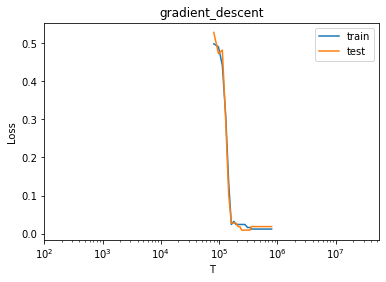

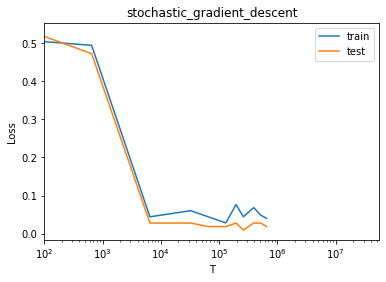

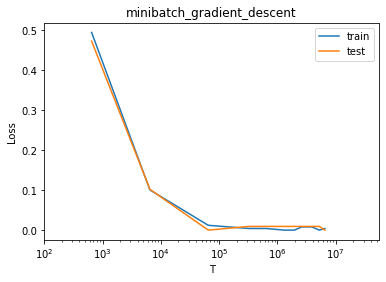

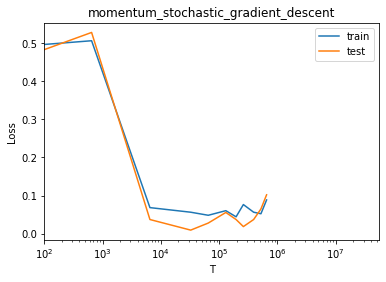

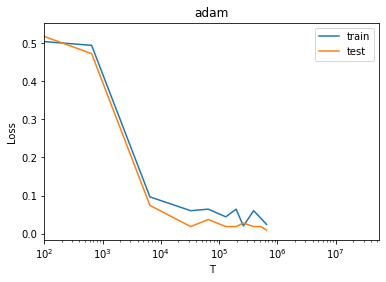

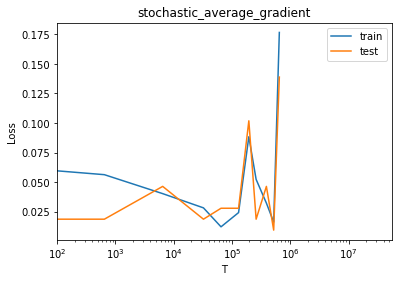

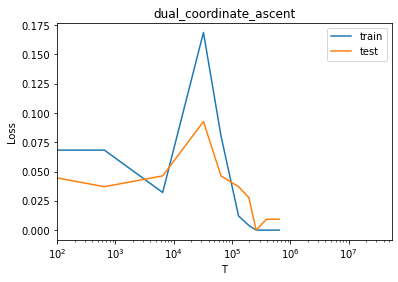

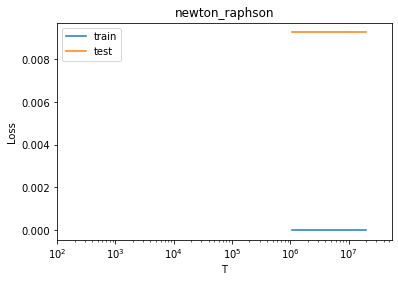

In [38]:
train_loss, test_loss = results["gradient_descent"]
capital_t = [X.shape[0] * X.shape[1] * t for t in range(5, 50)]
plot_loss_for_different_T(capital_t, train_loss, test_loss, title="gradient_descent")

train_loss, test_loss = results["stochastic_gradient_descent"]
capital_t = [X.shape[1] * t for t in DIFFERENT_POSSIBLE_ITERATIONS]
plot_loss_for_different_T(capital_t, train_loss, test_loss, title="stochastic_gradient_descent")

train_loss, test_loss = results["minibatch_gradient_descent"]
capital_t = [X.shape[1] * 10 * t for t in DIFFERENT_POSSIBLE_ITERATIONS]
plot_loss_for_different_T(capital_t, train_loss, test_loss, title="minibatch_gradient_descent")

train_loss, test_loss = results["momentum_stochastic_gradient_descent"]
capital_t = [X.shape[1] * t for t in DIFFERENT_POSSIBLE_ITERATIONS]
plot_loss_for_different_T(capital_t, train_loss, test_loss, title="momentum_stochastic_gradient_descent")

train_loss, test_loss = results["adam"]
capital_t = [X.shape[1] * t for t in DIFFERENT_POSSIBLE_ITERATIONS]
plot_loss_for_different_T(capital_t, train_loss, test_loss, title="adam")

train_loss, test_loss = results["stochastic_average_gradient"]
capital_t = [X.shape[1] * t for t in DIFFERENT_POSSIBLE_ITERATIONS]
plot_loss_for_different_T(capital_t, train_loss, test_loss, title="stochastic_average_gradient")

train_loss, test_loss = results["dual_coordinate_ascent"]
capital_t = [X.shape[1] * t for t in DIFFERENT_POSSIBLE_ITERATIONS]
plot_loss_for_different_T(capital_t, train_loss, test_loss, title="dual_coordinate_ascent")

train_loss, test_loss = results["newton_raphson"]
capital_t = [X.shape[0] * X.shape[1]**2 * t for t in range(1, 20, 2)]
plot_loss_for_different_T(capital_t, train_loss, test_loss, title="newton_raphson")

From our observations and test, the fastest algorithms to converge are minibatch gradient descent and stochastic gradient descent. From a quality perspective Newton Raphson is the best, but it takes much longer to train the model.